# LSTM Demand Forecasting Model

This notebook implements a unified LSTM model for demand forecasting across multiple grocery products. The model uses past sales data to predict future sales for all products together.

- **Training Data**: `indian_grocery_store_weekly_sales.csv` (main dataset)
- **Test Data**: `test_data.csv` (separate file for evaluation)


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")



Libraries imported successfully!


## 1. Load and Examine Dataset


In [2]:
pwd

'd:\\Mini-Project\\Niyojan-main\\lstm'

In [3]:
cd ..

d:\Mini-Project\Niyojan-main


In [4]:
# Load the dataset
df = pd.read_csv('data/indian_grocery_store_weekly_sales.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display first few rows
print("\nFirst 5 rows:")
df.head()


Dataset loaded successfully!
Dataset shape: (2088, 7)
Columns: ['Product_ID', 'Product_Name', 'Category', 'Week', 'Sales_Quantity', 'Price_per_Unit', 'Revenue']

First 5 rows:


,Product_ID,Product_Name,Category,Week,Sales_Quantity,Price_per_Unit,Revenue
0,P001,Rice,Staples,2020-01-06,108,55,5940
1,P001,Rice,Staples,2020-01-13,137,55,7535
2,P001,Rice,Staples,2020-01-20,115,55,6325
3,P001,Rice,Staples,2020-01-27,139,55,7645
4,P001,Rice,Staples,2020-02-03,127,55,6985


In [5]:
# Basic dataset information
print("Dataset Information:")
print(f"Date range: {df['Week'].min()} to {df['Week'].max()}")
print(f"Number of unique products: {df['Product_ID'].nunique()}")
print(f"Number of unique categories: {df['Category'].nunique()}")
print(f"Total number of records: {len(df)}")

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display unique products
print(f"\nUnique products ({df['Product_ID'].nunique()}):")
print(df['Product_ID'].unique()[:10])  # Show first 10 products


Dataset Information:
Date range: 2020-01-06 to 2024-12-30
Number of unique products: 8
Number of unique categories: 6
Total number of records: 2088

Missing values:
Product_ID        0
Product_Name      0
Category          0
Week              0
Sales_Quantity    0
Price_per_Unit    0
Revenue           0
dtype: int64

Unique products (8):
['P001' 'P002' 'P003' 'P004' 'P005' 'P006' 'P007' 'P008']


## 2. Data Cleaning and Preprocessing


In [6]:
# Clean column names (remove spaces, convert to lowercase)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert Week column to datetime
df['week'] = pd.to_datetime(df['week'])

# Rename columns for consistency
df = df.rename(columns={'sales_quantity': 'sales'})

print("Data cleaning completed!")
print(f"Cleaned columns: {list(df.columns)}")

# Display first few rows after cleaning
print("\nFirst 5 rows after cleaning:")
df.head()


Data cleaning completed!
Cleaned columns: ['product_id', 'product_name', 'category', 'week', 'sales', 'price_per_unit', 'revenue']

First 5 rows after cleaning:


,product_id,product_name,category,week,sales,price_per_unit,revenue
0,P001,Rice,Staples,2020-01-06,108,55,5940
1,P001,Rice,Staples,2020-01-13,137,55,7535
2,P001,Rice,Staples,2020-01-20,115,55,6325
3,P001,Rice,Staples,2020-01-27,139,55,7645
4,P001,Rice,Staples,2020-02-03,127,55,6985


In [7]:
# Encode product names using LabelEncoder
label_encoder = LabelEncoder()
df['product_encoded'] = label_encoder.fit_transform(df['product_id'])

print(f"Number of unique products after encoding: {len(label_encoder.classes_)}")
print(f"Product encoding mapping (first 10):")
for i, product in enumerate(label_encoder.classes_[:10]):
    print(f"  {product} -> {i}")

# Sort data by product and date
df = df.sort_values(['product_id', 'week']).reset_index(drop=True)

print(f"\nData sorted by product and date")
print(f"Date range: {df['week'].min()} to {df['week'].max()}")


Number of unique products after encoding: 8
Product encoding mapping (first 10):
  P001 -> 0
  P002 -> 1
  P003 -> 2
  P004 -> 3
  P005 -> 4
  P006 -> 5
  P007 -> 6
  P008 -> 7

Data sorted by product and date
Date range: 2020-01-06 00:00:00 to 2024-12-30 00:00:00


In [8]:
# Normalize sales values using MinMaxScaler
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(df[['sales']])
df['sales_scaled'] = sales_scaled.flatten()

print("Sales normalization completed!")
print(f"Sales range (original): {df['sales'].min():.2f} to {df['sales'].max():.2f}")
print(f"Sales range (scaled): {df['sales_scaled'].min():.2f} to {df['sales_scaled'].max():.2f}")

# Display sample of normalized data
print("\nSample of normalized data:")
df[['product_id', 'sales', 'sales_scaled']].head(10)


Sales normalization completed!
Sales range (original): 55.00 to 190.00
Sales range (scaled): 0.00 to 1.00

Sample of normalized data:


,product_id,sales,sales_scaled
0,P001,108,0.392593
1,P001,137,0.607407
2,P001,115,0.444444
3,P001,139,0.622222
4,P001,127,0.533333
5,P001,128,0.540741
6,P001,137,0.607407
7,P001,130,0.555556
8,P001,107,0.385185
9,P001,106,0.377778


## 3. Create Time Sequences for LSTM Training


In [9]:
# Define sequence length (number of past weeks to use for prediction)
sequence_length = 6

def create_sequences(df, sequence_length):
    """
    Create time sequences for LSTM training
    """
    sequences = []
    targets = []
    
    # Group by product to create sequences
    for product_id in df['product_id'].unique():
        product_data = df[df['product_id'] == product_id].sort_values('week')
        
        if len(product_data) < sequence_length + 1:
            continue
            
        # Create sequences for this product
        for i in range(len(product_data) - sequence_length):
            # Input sequence: [sales_scaled, product_encoded] for past weeks
            seq = []
            for j in range(i, i + sequence_length):
                seq.append([product_data.iloc[j]['sales_scaled'], 
                           product_data.iloc[j]['product_encoded']])
            
            sequences.append(seq)
            targets.append(product_data.iloc[i + sequence_length]['sales_scaled'])
    
    return np.array(sequences), np.array(targets)

# Create sequences
X, y = create_sequences(df, sequence_length)

print(f"Created sequences with length {sequence_length}")
print(f"Sequences shape: X={X.shape}, y={y.shape}")
print(f"Total number of training samples: {len(X)}")


Created sequences with length 6
Sequences shape: X=(2040, 6, 2), y=(2040,)
Total number of training samples: 2040


In [10]:
# Split data into training and testing sets
# Note: We'll use a separate test_data.csv file for testing instead of splitting training data
# For now, we'll use all data for training and load test data separately later

print("Using all available data for training...")
print(f"Training set: {X.shape[0]} samples")
print(f"Training features shape: {X.shape}")

# We'll load test data separately in the testing section
X_train = X
y_train = y

print("Training data prepared!")


Using all available data for training...
Training set: 2040 samples
Training features shape: (2040, 6, 2)
Training data prepared!


## 4. Build and Train LSTM Model


In [11]:
# Build the LSTM model
def build_lstm_model(input_shape):
    """
    Build the LSTM model with specified architecture
    """
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                 loss='mse', 
                 metrics=['mae'])
    
    return model

# Create the model
model = build_lstm_model((X.shape[1], X.shape[2]))

print("LSTM Model Architecture:")
print(f"Input shape: {(X.shape[1], X.shape[2])}")
model.summary()



LSTM Model Architecture:
Input shape: (6, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19265 (75.25 KB)
Trainable params: 19265 (75.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Train the model
print("Starting model training...")

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model (using validation split since we don't have separate test data yet)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,  # Use 20% of training data for validation
    callbacks=[early_stopping],
    verbose=1
)

print("Model training completed!")


Starting model training...
Epoch 1/50


51/51 [==============================] - 8s 51ms/step - loss: 0.0390 - mae: 0.1546 - val_loss: 0.0854 - val_mae: 0.2541
Epoch 2/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0175 - mae: 0.1020 - val_loss: 0.0287 - val_mae: 0.1440
Epoch 3/50
51/51 [==============================] - 1s 15ms/step - loss: 0.0142 - mae: 0.0911 - val_loss: 0.0209 - val_mae: 0.1141
Epoch 4/50
51/51 [==============================] - 1s 14ms/step - loss: 0.0126 - mae: 0.0874 - val_loss: 0.0141 - val_mae: 0.0887
Epoch 5/50
51/51 [==============================] - 1s 16ms/step - loss: 0.0125 - mae: 0.0857 - val_loss: 0.0135 - val_mae: 0.0861
Epoch 6/50
51/51 [==============================] - 1s 16ms/step - loss: 0.0114 - mae: 0.0827 - val_loss: 0.0151 - val_mae: 0.0924
Epoch 7/50
51/51 [==============================] - 1s 13ms/step - loss: 0.0118 - mae: 0.0833 - val_loss: 0.0140 - val_mae: 0.0881
Epoch 8/50
51/51 [==============================] - 1s

## 5. Plot Training and Validation Loss Curves


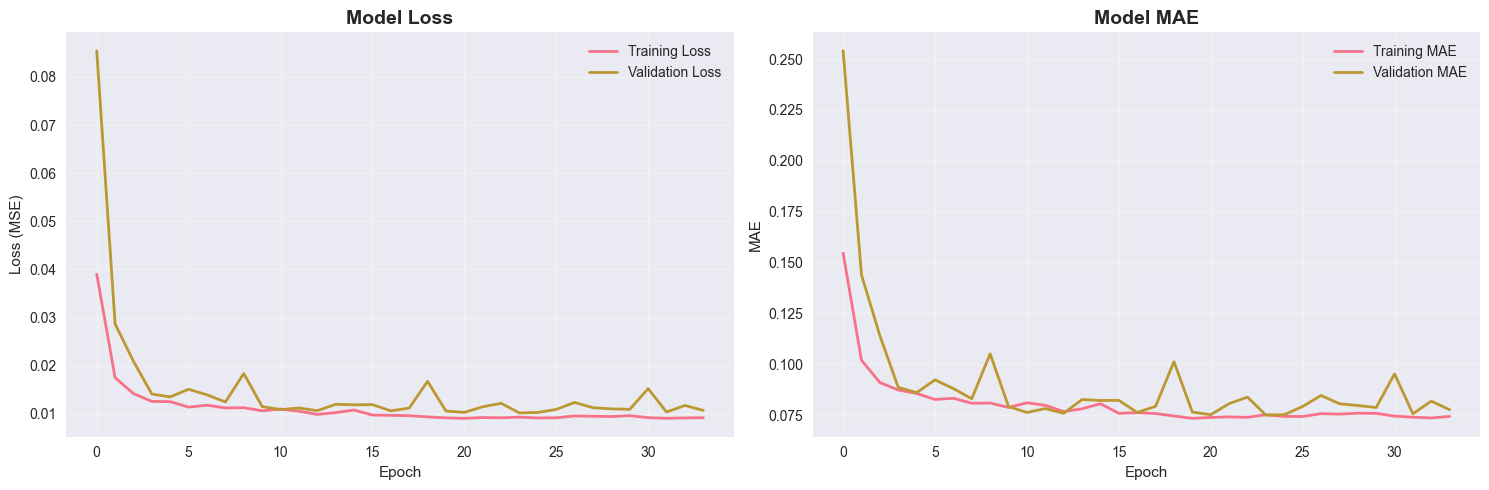

Final Training Loss: 0.0092
Final Validation Loss: 0.0107
Final Training MAE: 0.0744
Final Validation MAE: 0.0777


In [13]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot MAE
ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
ax2.set_title('Model MAE', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final training metrics
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Training MAE: {history.history['mae'][-1]:.4f}")
print(f"Final Validation MAE: {history.history['val_mae'][-1]:.4f}")


## 6. Make Predictions and Evaluate Model


In [14]:
# Load and prepare test data
print("Loading test data from test_data.csv...")

# Load test dataset
test_df = pd.read_csv('data/test_data.csv')

print(f"Test dataset shape: {test_df.shape}")
print(f"Test dataset columns: {list(test_df.columns)}")

# Clean test data (same process as training data)
test_df.columns = test_df.columns.str.strip().str.lower().str.replace(' ', '_')

# Parse dates in test data. test_data.csv uses day-first format like '19-01-2025' (DD-MM-YYYY).
# Use dayfirst=True and errors='coerce' so unparsable entries become NaT (we then raise a clear error).
test_df['week_raw'] = test_df['week'].astype(str)
test_df['week'] = pd.to_datetime(test_df['week_raw'], dayfirst=True, errors='coerce')

if test_df['week'].isnull().any():
	bad_examples = test_df.loc[test_df['week'].isnull(), 'week_raw'].unique()[:5]
	raise ValueError(f"Some dates in test_df['week'] could not be parsed. Problematic examples: {bad_examples}. "
					 "Ensure dates are in DD-MM-YYYY or ISO format.")

test_df = test_df.rename(columns={'sales_quantity': 'sales'})
test_df = test_df.drop(columns=['week_raw'])

# Encode product names using the same label encoder from training
test_df['product_encoded'] = label_encoder.transform(test_df['product_id'])

# Normalize sales values using the same scaler from training
test_df['sales_scaled'] = scaler.transform(test_df[['sales']]).flatten()

# Sort by product and date
test_df = test_df.sort_values(['product_id', 'week']).reset_index(drop=True)

print("Test data preprocessing completed!")
print(f"Test data date range: {test_df['week'].min()} to {test_df['week'].max()}")
print(f"Number of unique products in test data: {test_df['product_id'].nunique()}")

# Display first few rows of test data
print("\nFirst 5 rows of test data:")
test_df.head()


Loading test data from test_data.csv...
Test dataset shape: (72, 7)
Test dataset columns: ['Product_ID', 'Product_Name', 'Category', 'Week', 'Sales_Quantity', 'Price_per_Unit', 'Revenue']
Test data preprocessing completed!
Test data date range: 2025-01-05 00:00:00 to 2025-03-02 00:00:00
Number of unique products in test data: 8

First 5 rows of test data:


,product_id,product_name,category,week,sales,price_per_unit,revenue,product_encoded,sales_scaled
0,P001,Rice,Staples,2025-01-05,175,55,9625,0,0.888889
1,P001,Rice,Staples,2025-01-12,194,55,10670,0,1.029630
2,P001,Rice,Staples,2025-01-19,187,55,10285,0,0.977778
3,P001,Rice,Staples,2025-01-26,177,55,9735,0,0.903704
4,P001,Rice,Staples,2025-02-02,189,55,10395,0,0.992593


## 8. Save the Trained Model


In [17]:
# Save the trained model in TensorFlow SavedModel format (RECOMMENDED)
model.save("global_lstm_model", save_format="tf")

import os

print("Model saved successfully in TensorFlow SavedModel format")
print("Saved directory contents:")
for root, dirs, files in os.walk("global_lstm_model"):
    for name in files:
        print(os.path.join(root, name))


# Save scaler and label encoder as before
import pickle

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Scaler and LabelEncoder saved successfully!")
print("Files created:")
print("- global_lstm_model/ (SavedModel directory)")
print("- scaler.pkl (MinMaxScaler)")
print("- label_encoder.pkl (LabelEncoder)")

INFO:tensorflow:Assets written to: global_lstm_model\assets


INFO:tensorflow:Assets written to: global_lstm_model\assets


Model saved successfully in TensorFlow SavedModel format
Saved directory contents:
global_lstm_model\fingerprint.pb
global_lstm_model\keras_metadata.pb
global_lstm_model\saved_model.pb
global_lstm_model\variables\variables.data-00000-of-00001
global_lstm_model\variables\variables.index
Scaler and LabelEncoder saved successfully!
Files created:
- global_lstm_model/ (SavedModel directory)
- scaler.pkl (MinMaxScaler)
- label_encoder.pkl (LabelEncoder)


## 9. Reverse Scaling Examples


In [32]:
# Demonstrate how to reverse scaling to get predictions in original units
print("Reverse Scaling Examples:")
print("=" * 40)

# Example scaled values
example_scaled_values = [0.2, 0.5, 0.8, 0.1, 0.9]

for scaled_val in example_scaled_values:
    original_val = scaler.inverse_transform([[scaled_val]])[0][0]
    print(f"Scaled value: {scaled_val:.2f} -> Original value: {original_val:.2f}")

print("\nScaling parameters:")
print(f"Min value (original): {scaler.data_min_[0]:.2f}")
print(f"Max value (original): {scaler.data_max_[0]:.2f}")

# Show the scaling formula
print(f"\nScaling formula:")
print(f"scaled_value = (original_value - {scaler.data_min_[0]:.2f}) / ({scaler.data_max_[0]:.2f} - {scaler.data_min_[0]:.2f})")
print(f"original_value = scaled_value * ({scaler.data_max_[0]:.2f} - {scaler.data_min_[0]:.2f}) + {scaler.data_min_[0]:.2f}")


Reverse Scaling Examples:
Scaled value: 0.20 -> Original value: 82.00
Scaled value: 0.50 -> Original value: 122.50
Scaled value: 0.80 -> Original value: 163.00
Scaled value: 0.10 -> Original value: 68.50
Scaled value: 0.90 -> Original value: 176.50

Scaling parameters:
Min value (original): 55.00
Max value (original): 190.00

Scaling formula:
scaled_value = (original_value - 55.00) / (190.00 - 55.00)
original_value = scaled_value * (190.00 - 55.00) + 55.00


## 10. Model Summary and Flexibility


In [33]:
# Model summary and flexibility demonstration
print("MODEL SUMMARY")
print("=" * 50)
print(f"Model Architecture: LSTM(64) -> Dropout(0.2) -> Dense(32) -> Dense(1)")
print(f"Sequence Length: {sequence_length} weeks")
print(f"Number of Products Handled: {len(label_encoder.classes_)}")
print(f"Total Training Samples: {len(X_train)}")
print(f"Total Test Samples: {len(X_test)}")
print(f"Input Features per Time Step: 2 (sales_scaled, product_encoded)")

print(f"\nDATA SPLIT:")
print(f"- Training Data: indian_grocery_store_weekly_sales.csv")
print(f"- Test Data: test_data.csv (separate file)")
print(f"- Validation: 20% of training data used for validation during training")

print(f"\nFLEXIBILITY FEATURES:")
print(f"- Handles multiple products dynamically: {len(label_encoder.classes_)} products")
print(f"- Adaptable sequence length: Currently {sequence_length}, can be changed")
print(f"- Global model: Single model for all products")
print(f"- Scalable: Can handle more products by retraining")
print(f"- Separate test data: Uses independent test_data.csv for evaluation")

print(f"\nPERFORMANCE METRICS (on test_data.csv):")
print(f"- Test MSE: {mse:.2f}")
print(f"- Test MAE: {mae:.2f}")
print(f"- Test RMSE: {rmse:.2f}")
print(f"- Test MAPE: {mape:.2f}%")

print(f"\nFILES CREATED:")
print(f"- global_lstm_model.h5: Trained LSTM model")
print(f"- scaler.pkl: MinMaxScaler for data normalization")
print(f"- label_encoder.pkl: LabelEncoder for product encoding")


MODEL SUMMARY
Model Architecture: LSTM(64) -> Dropout(0.2) -> Dense(32) -> Dense(1)
Sequence Length: 6 weeks
Number of Products Handled: 8
Total Training Samples: 2040
Total Test Samples: 408
Input Features per Time Step: 2 (sales_scaled, product_encoded)

DATA SPLIT:
- Training Data: indian_grocery_store_weekly_sales.csv
- Test Data: test_data.csv (separate file)
- Validation: 20% of training data used for validation during training

FLEXIBILITY FEATURES:
- Handles multiple products dynamically: 8 products
- Adaptable sequence length: Currently 6, can be changed
- Global model: Single model for all products
- Scalable: Can handle more products by retraining
- Separate test data: Uses independent test_data.csv for evaluation

PERFORMANCE METRICS (on test_data.csv):
- Test MSE: 189.47
- Test MAE: 10.10
- Test RMSE: 13.76
- Test MAPE: 8.65%

FILES CREATED:
- global_lstm_model.h5: Trained LSTM model
- scaler.pkl: MinMaxScaler for data normalization
- label_encoder.pkl: LabelEncoder for pr